In [5]:
from fik import *

from os import path
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

logs_dir = 'FLIGHT'

gm_logs, cf_logs, ff_logs = [
    DATALOG.split_runs(path.join(logs_dir, devid, 'DATALOG.TXT'))
    for devid in ['GM', 'CF', 'FF']
]

print(gm_logs, cf_logs, ff_logs)

for dl, dl_cf in zip(ff_logs, cf_logs):
    if dl_cf.start_ts is None:
        sys.stderr.write("Skipping FF candy flux plot -- counterpart CF is without fix")
        continue
    
    dl.candy.index = dl_cf.start_ts + pd.to_timedelta(dl.candy['Time'], unit='sec')


[<fik.DATALOG object at 0x7f81c340f278>] [<fik.DATALOG object at 0x7f81c7b655f8>] [<fik.DATALOG object at 0x7f81c3904588>]


No fix for run of 11740 lines at $AIRDOS,FF,96051b4,1290c00806a200920856a000a00000c9


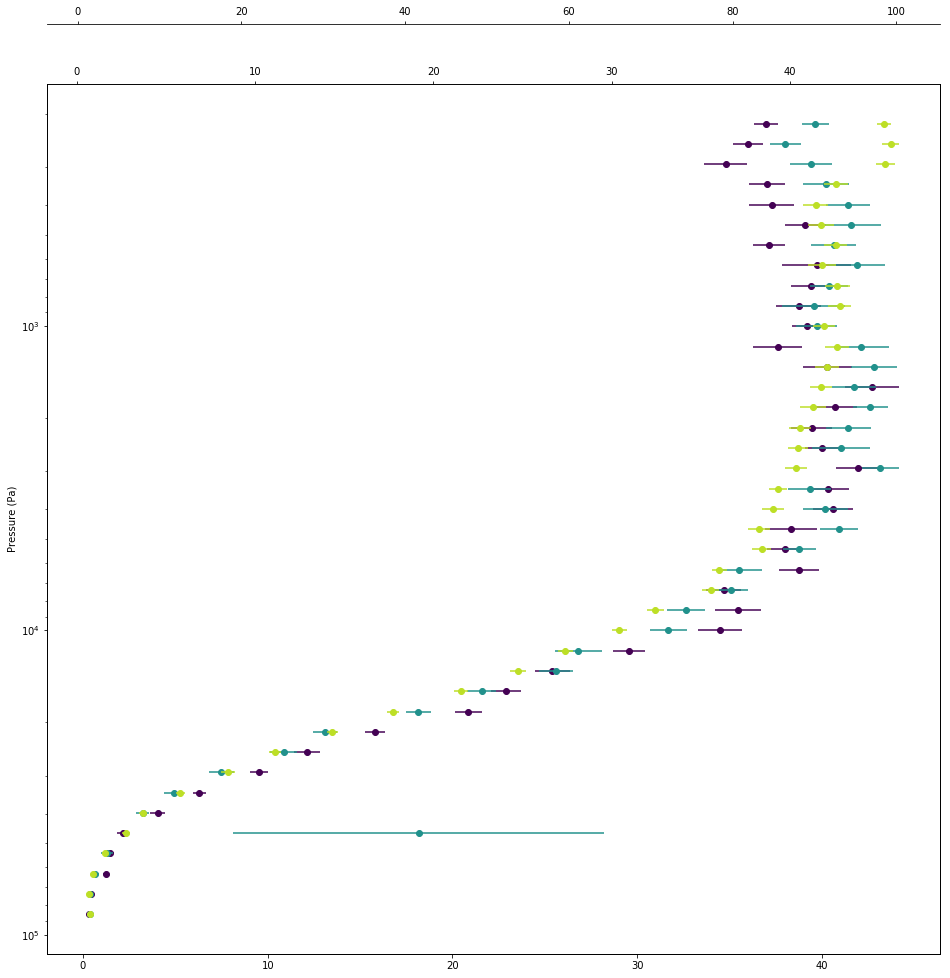

In [6]:
cf_merged = pd.concat([log.candy for log in cf_logs])

def pressure_for(m):
    alt = cf_merged['Pressure']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)

def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])

def cf_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,50:200], axis=1), index=candy.index)
    return flux

def ff_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,3:], axis=1), index=candy.index)
    return flux

intensities = [
    (logs[0].greeting, pd.concat([flux_acc(d) for d in logs]))
    for logs, flux_acc in zip((cf_logs, ff_logs, gm_logs),
        (lambda m: cf_flux(m.candy),
         lambda m: ff_flux(m.candy),
         lambda m: m.gm['GMCount']))
]

tstart = pd.Timestamp(year=2019, month=9, day=5, hour=4, minute=30, tz='UTC') #cf_logs[0].candy.index[0]
tto = pd.Timestamp(year=2019, month=9, day=5, hour=8, minute=0, tz='UTC') #cf_logs[0].candy.index[-1]

intensities = [
    (a, b[np.logical_and(b.index > tstart, b.index < tto)])
    for a, b in intensities
]

fig = plt.figure(figsize=(16, 16))
fig.gca().invert_yaxis()
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel('Pressure (Pa)')
host.set_yscale('log')

for I_, ax, col in zip(intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    greet, I = I_
    m = pd.DataFrame({'I': I, 'P': pressure_for(I)}).dropna()
    k = (pd.Series(data=m['I'].values, index=m['P'].values).dropna().groupby(lambda x: 10**(int(np.log10(x)*15)/15)))
    mean = k.mean()
    index = mean.index
    stderr = k.sem()
    ax.errorbar(mean.values, index, color=col, label=greet, xerr=stderr, fmt='o')

#host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))  

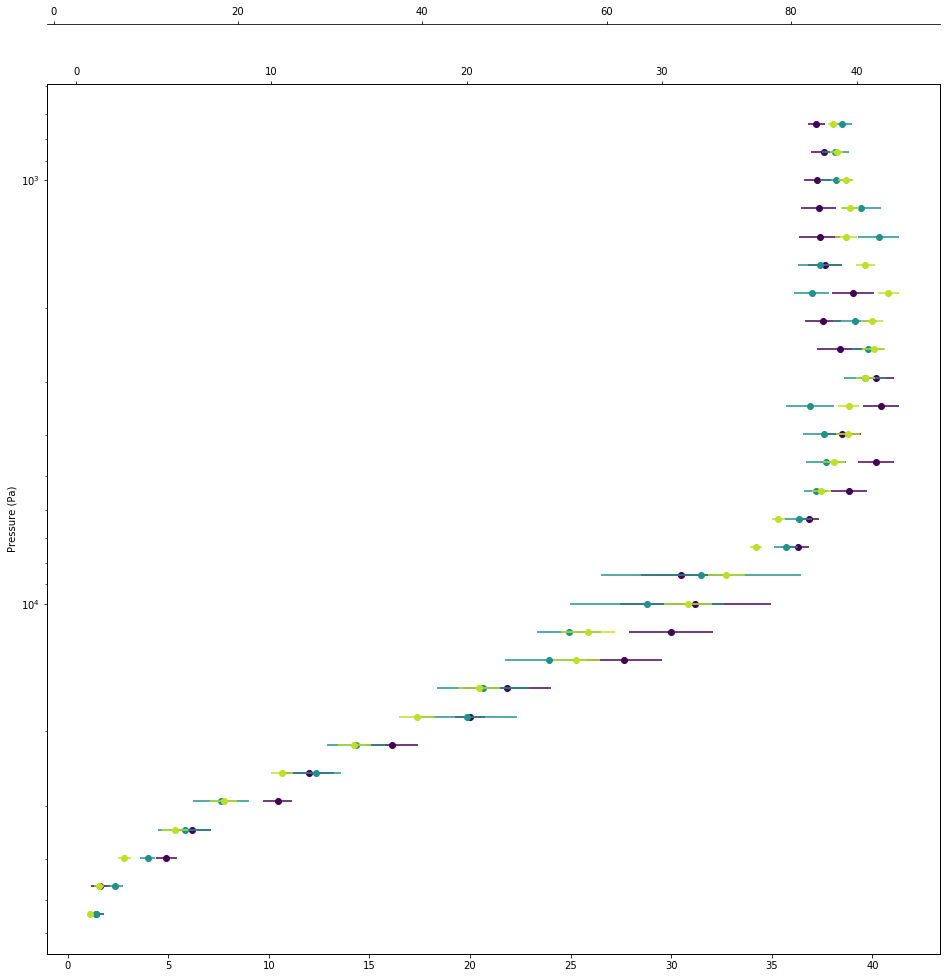

In [8]:
cf_merged = pd.concat([log.candy for log in cf_logs])

def pressure_for(m):
    alt = cf_merged['Pressure']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)

def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])

def cf_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,50:200], axis=1), index=candy.index)
    return flux

def ff_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,3:], axis=1), index=candy.index)
    return flux

intensities = [
    (logs[0].greeting, pd.concat([flux_acc(d) for d in logs]))
    for logs, flux_acc in zip((cf_logs, ff_logs, gm_logs),
        (lambda m: cf_flux(m.candy),
         lambda m: ff_flux(m.candy),
         lambda m: m.gm['GMCount']))
]

tstart = pd.Timestamp(year=2019, month=9, day=5, hour=14, minute=30, tz='UTC') #cf_logs[0].candy.index[0]
tto = pd.Timestamp(year=2019, month=9, day=5, hour=17, minute=30, tz='UTC') #cf_logs[0].candy.index[-1]

intensities = [
    (a, b[np.logical_and(b.index > tstart, b.index < tto)])
    for a, b in intensities
]

fig = plt.figure(figsize=(16, 16))
fig.gca().invert_yaxis()
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel('Pressure (Pa)')
host.set_yscale('log')

for I_, ax, col in zip(intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    greet, I = I_
    m = pd.DataFrame({'I': I, 'P': pressure_for(I)}).dropna()
    k = (pd.Series(data=m['I'].values, index=m['P'].values).dropna().groupby(lambda x: 10**(int(np.log10(x)*15)/15)))
    mean = k.mean()
    index = mean.index
    stderr = k.sem()
    ax.errorbar(mean.values, index, color=col, label=greet, xerr=stderr, fmt='o')

#host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))  